In [1]:
import numpy as np
import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.units import galactic
from astropy.coordinates import SkyCoord, Distance
import gala.coordinates as gc
#import popsims
import matplotlib.pyplot as plt
#%matplotlib notebook
from tqdm import tqdm
from astropy.constants import G
#import HSS

import  h5py
import imageio
import seaborn as sns
import matplotlib as mpl
import matplotlib.animation as animation
import astropy.coordinates as astro_coord
import popsims
import astropy.units as u
import pandas as pd
from astropy.io import ascii

from shapey import Box
from galpy.actionAngle import actionAngleIsochroneApprox
from galpy.potential import IsochronePotential
from galpy.potential import MWPotential
import astropy

#plt.style.use('dark_background')
%matplotlib inline

Adding 2404 sources from /Users/caganze/research/splat//resources/Spectra/Public/SPEX-PRISM/ to spectral database
Adding 145 sources from /Users/caganze/research/splat//resources/Spectra/Public/LRIS-RED/ to spectral database
Adding 89 sources from /Users/caganze/research/splat//resources/Spectra/Public/MAGE/ to spectral database


In [2]:
DATA_FOLDER='/users/caganze/research/J1624/data/'
FIG_FOLDER='/users/caganze/research/J1624/figures/'

In [3]:
#coordinate frame
_ = astro_coord.galactocentric_frame_defaults.set('v4.0')
v_sun = astro_coord.CartesianDifferential([11.1, 220 + 24.0, 7.25]*u.km/u.s)
galcen_frame =astro_coord.Galactocentric(galcen_distance=8.2*u.kpc,
                                    galcen_v_sun=v_sun)

#potential
pot=gp.MilkyWayPotential()
H = gp.Hamiltonian(pot)


In [4]:
(11.1, 220+24.0, 7.25 )

(11.1, 244.0, 7.25)

In [5]:
def get_phase_space(ra, dec, pmracosdec, pmdec, distance, rv ):
    #ra, dec in degree
    #proper motions in mas/yr
    #distance in pc
    #rv in km/s
    coord=SkyCoord(ra=ra*u.degree, dec=dec*u.degree,  
               pm_ra_cosdec= pmracosdec *u.mas/u.yr, pm_dec=pmdec*u.mas/u.yr, \
               distance=distance*u.pc, 
              radial_velocity= rv*u.km/u.s)
    #phase space position
    pos=gd.PhaseSpacePosition(coord.transform_to(galcen_frame).cartesian)
    

    return coord, pos

In [6]:
J1624_coord={'ra':46.0684208, \
              'dec': -32.2037824,\
              'pmra':np.random.normal(-25.809, 0.159, 1000),
              'pmdec':np.random.normal(-185.783, 0.122, 1000),
              'distance':np.random.normal(16.9465, 0.0356, 1000),
              'rv': np.random.normal(0.23, 0.08, 1000)}
J1624_METAL=(0.29 , 0.07)


In [7]:
#run the orbit a 1000 times incorporating the instrinsic uncertainties in rv,
#distance and proper motion

In [8]:
j1624c, pos=get_phase_space(J1624_coord['ra'], J1624_coord['dec'],\
                       J1624_coord['pmra']*np.cos(J1624_coord['dec']*u.degree), \
                       J1624_coord['pmdec'], J1624_coord['distance'], J1624_coord['rv'])

In [9]:
def compute_actions(pos, plot_all_orbit=False, alpha=1., print_pericenter=False):
    orbit=gp.Hamiltonian(pot).integrate_orbit(pos, dt=3*u.Myr, t1=0*u.Myr, \
                                              t2=2.5*u.Gyr)
    #plot 
    orbit_to_plot=orbit[:,0]
    if plot_all_orbit: orbit_to_plot=orbit
    oplot=orbit_to_plot.cylindrical.plot( components=['rho', 'z', 'v_z'],  \
                                      units=[u.pc, u.pc, u.km/u.s] ,alpha=alpha, c='#0074D9')
    #documentation: http://gala.adrian.pw/en/latest/dynamics/actionangle.html
    toy_potential = gd.fit_isochrone(orbit[:,0])
    print (toy_potential)
    print (np.shape(orbit.z))
    result = [gd.find_actions(orbit[:,idx], N_max=10, toy_potential=toy_potential) \
              for idx in tqdm(np.arange(np.shape(orbit)[-1]))]
    if  print_pericenter:
        apos=[orbit[:,idx].apocenter() for idx in tqdm(np.arange(np.shape(orbit)[-1]))]
        peris=[orbit[:,idx].pericenter() for idx in tqdm(np.arange(np.shape(orbit)[-1]))]
        print ('apocenter --- {} +/- {}'.format(np.nanmedian(u.Quantity(apos)),\
                                                np.nanstd(u.Quantity(apos))))
        print ('pericenter --- {} +/- {}'.format(np.nanmedian(u.Quantity(peris)),\
                                                 np.nanstd(u.Quantity(peris))))
    return pd.DataFrame.from_records(result), oplot


def compute_orbit_and_actions_galpy(pos, plot_all_orbit=False, alpha=1.):
    orbit=gp.Hamiltonian(pot).integrate_orbit(pos, dt=5*u.Myr, t1=0*u.Myr, \
                                              t2=2.5*u.Gyr)
    #plot 
    orbit_to_plot=orbit[:,0]
    if plot_all_orbit: orbit_to_plot=orbit
    oplot=orbit_to_plot.cylindrical.plot( components=['rho', 'z', 'v_z'],  \
                                      units=[u.pc, u.pc, u.km/u.s] ,alpha=alpha, c='#0074D9')
    ts=orbit.t
    galpyo=orbit.to_galpy_orbit()
    #ip= IsochronePotential(b=1.,normalize=1.)
    aAI= actionAngleIsochroneApprox(pot=pot.to_galpy_potential(), b=1.)
    #jfa=aAI.actionsFreqsAngles(galpyo.R(),galpyo.vR(),galpyo.vT(),galpyo.z(),\
    #                   galpyo.vz(),galpyo.phi())
    print (np.shape(galpyo.R()))
    jfa=  aAI.actionsFreqsAngles(galpyo.R().T,galpyo.vR().T,galpyo.vT().T,galpyo.z().T,\
                       galpyo.vz().T,galpyo.phi().T)
    return ts, jfa, oplot

In [10]:
from galpy.actionAngle import actionAngleIsochroneApprox
from galpy.potential import LogarithmicHaloPotential
lp= LogarithmicHaloPotential(normalize=1.,q=0.9)
aAIA= actionAngleIsochroneApprox(pot=lp,b=0.8)

In [11]:
import gala
gala.__version__

'1.4.2.dev60+g386a9d23'

In [12]:
pot.to_galpy_potential()

  0%|          | 0/1000 [00:00<?, ?it/s]

IsochronePotential
(834, 1000)


100%|██████████| 1000/1000 [00:17<00:00, 58.80it/s]
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


apocenter --- 9.070345028513731 kpc +/- 0.0024372587262519287 kpc
pericenter --- 7.763879554301031 kpc +/- 0.0011194866746027958 kpc


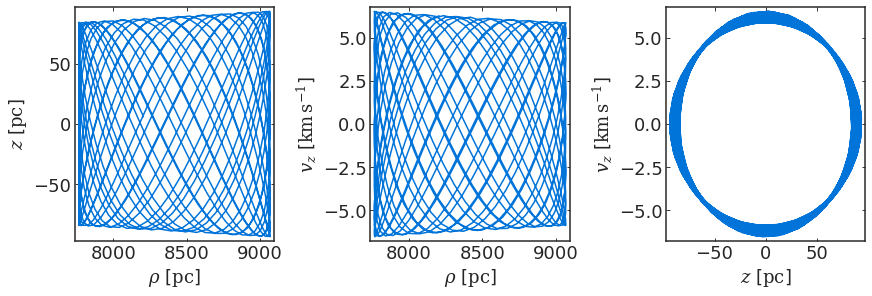

In [13]:
ares=compute_actions(pos, plot_all_orbit=False, alpha=1., print_pericenter=True)

In [234]:
(9.07-8.2)*1000, (9.07-7.7)*1000

(870.000000000001, 1370.0)

In [223]:
ares[0]['actions'][0][0].unit.to(u.kpc**2/u.Gyr)

1000.0

In [229]:
js=np.vstack(ares[0]['actions'].apply(lambda x: np.array(x)).values)
angles=np.vstack(ares[0]['angles'].apply(lambda x: np.array(x)).values)

In [224]:
np.nanmean(js[:,0])*1000, np.nanstd(js[:,0])*1000

(8.1655109065209, 0.0282822851498845)

In [225]:
np.nanmean(js[:,1])*1000, np.nanstd(js[:,1])*1000

(-1975.7721949839938, 0.2969010269681072)

In [226]:
np.nanmean(js[:,-1])*1000, np.nanstd(js[:,-1])*1000

(0.2864111099476341, 0.006098185779751951)

In [230]:
ares[0]['freqs']

0      [0.03819117388397853 rad / Myr, -0.02803232037...
1      [0.0381783875311511 rad / Myr, -0.028023251834...
2      [0.038187469813375195 rad / Myr, -0.0280295252...
3      [0.03817321839549242 rad / Myr, -0.02801928113...
4      [0.03818058752647841 rad / Myr, -0.02802463264...
                             ...                        
995    [0.03819268042375631 rad / Myr, -0.02803345649...
996    [0.03818734809678463 rad / Myr, -0.02802962062...
997    [0.038178048109877766 rad / Myr, -0.0280229327...
998    [0.038190381811767656 rad / Myr, -0.0280317409...
999    [0.038183874093487814 rad / Myr, -0.0280271259...
Name: freqs, Length: 1000, dtype: object

In [18]:
ares[-1].savefig(FIG_FOLDER+'/galatic_orbit.pdf')

In [19]:

bensby=ascii.read(DATA_FOLDER+'/bensby_30pc_gaia1.txt', \
                        names ='ra              de    \
                                [Fe/H]       age1     l_age1     u_age1       \
                                ra_gaia              de_gaia        plx       eplx    \
                                pmra      epmra       pmde      epmde      \
                                rv        erv'.split()).to_pandas()

luck=ascii.read(DATA_FOLDER+'/luck_30pc_gaia1.txt', \
               names='ra              de     [Fe/H]       age1     l_age1    \
               u_age1         ra_gaia         de_gaia        plx       eplx      \
               pmra      epmra       pmde      epmde         rv   \
               erv '.split()).to_pandas()

casgr=ascii.read(DATA_FOLDER+'/casagrande_30pc_gaia1.txt', \
                 names='ra              de     [Fe/H]      ageMP     age16P     \
                 age84P              ra_gaia              de_gaia        \
                 plx       eplx       pmra      epmra       pmde      \
                 epmde         rv        erv'.split()).to_pandas()
spocs=ascii.read(DATA_FOLDER+'/spocs_30pc_gaia1.txt', \
                 names=' ra              de     [Fe/H]       age1     l_age1     u_age1          \
                 ra_gaia              de_gaia        plx       eplx       pmra   \
                 epmra       pmde      epmde         rv        erv '.split()).to_pandas()
                 


In [20]:
luck['pmracosdec']= luck.pmra*np.cos(luck.de*u.degree)
bensby['pmracosdec']= bensby.pmra*np.cos(bensby.de*u.degree)
spocs['pmracosdec']= spocs.pmra*np.cos(spocs.de*u.degree)
casgr['pmracosdec']= casgr.pmra*np.cos(casgr.de*u.degree)

In [21]:
comb=pd.concat([bensby, luck, spocs, casgr.rename(columns={'ageMP':'age1'})])

In [22]:
bcoord, bpos=get_phase_space(comb.ra_gaia.values, comb.de_gaia.values,\
                             comb.pmracosdec.values, \
                comb.pmde.values, 1000/comb.plx.values, comb.rv.values )

  0%|          | 0/1434 [00:00<?, ?it/s]

IsochronePotential
(834, 1434)


100%|██████████| 1434/1434 [13:15<00:00,  1.80it/s]


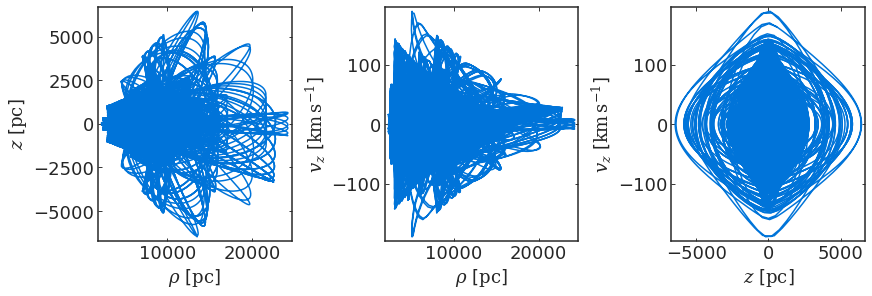

In [23]:
bensby_res=compute_actions(bpos, plot_all_orbit=True, alpha=1.)

In [24]:
bjs=np.vstack(bensby_res[0]['actions'].apply(lambda x: np.array(x)).values)
bas=np.vstack(bensby_res[0]['angles'].apply(lambda x: np.array(x)).values)
bfreqs=np.vstack(bensby_res[0]['freqs'].apply(lambda x: np.array(x)).values)

[(-0.01, 0.1), (-1.0, 10.0)]

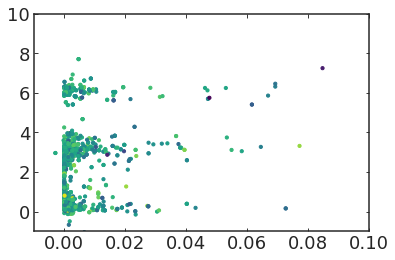

In [196]:
fig, ax=plt.subplots()
ax.scatter(bjs[:,-1], bas[:,-1], c=comb['[Fe/H]'], s=10, cmap='viridis')
ax.set(xlim=[-0.01, 0.1], ylim=[-1, 10])

In [140]:
bjs[:,2].min()

-4.479321297026925

In [279]:
comb['Jr']=bjs[:,0]*1000
comb['Jphi']=bjs[:,1]*1000
comb['Jz']=bjs[:,2]*1000
comb['vtot']=(bcoord.transform_to(galcen_frame).v_x**2+
                bcoord.transform_to(galcen_frame).v_y**2+
                bcoord.transform_to(galcen_frame).v_z**2)**0.5
comb['v_x']=bcoord.transform_to(galcen_frame).v_x
comb['v_y']=bcoord.transform_to(galcen_frame).v_y
comb['v_z']=bcoord.transform_to(galcen_frame).v_z

In [280]:
comb_r=comb.sample(n=int(1e5), replace=True)
mask= np.logical_and(comb_r.Jz>-6.5, comb_r['[Fe/H]'].between(-2, 2))

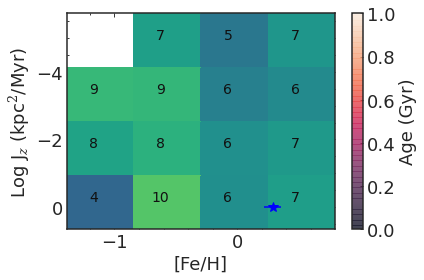

In [198]:
fig, ax=plt.subplots()

popsims.tools.plot_annotated_heatmap(ax, comb_r[['[Fe/H]', 'Jz', 'age1']][mask], 5,
                                     ['[Fe/H]', 'Jz', 'age1'], cmap='viridis', 
                           annotate='third_value', vmin=0, vmax=13, \
                                     textsize=14)
#c=ax.scatter(comb['[Fe/H]'],  comb.Jz, marker='+', c='r', alpha=0.5)


cbar=plt.colorbar(c)
cbar.ax.set(ylabel='Age (Gyr)')
ax.minorticks_on()
plt.tight_layout()


In [149]:
j1624c_total_v=(j1624c.transform_to(galcen_frame).v_x**2+
            j1624c.transform_to(galcen_frame).v_y**2+
                j1624c.transform_to(galcen_frame).v_z**2)**0.5



In [258]:

 np.nanmedian(j1624c.transform_to(galcen_frame).v_z ).value


6.33062724472429

In [265]:

 np.nanstd(j1624c.transform_to(galcen_frame).v_z ).value


0.067881677934503

In [260]:
np.nanmedian((j1624c.transform_to(galcen_frame).v_x**2+
            j1624c.transform_to(galcen_frame).v_y**2)**0.5).value

236.6295805849922

In [267]:
np.nanstd((j1624c.transform_to(galcen_frame).v_x**2+
            j1624c.transform_to(galcen_frame).v_y**2)**0.5).value

0.03624789686604486

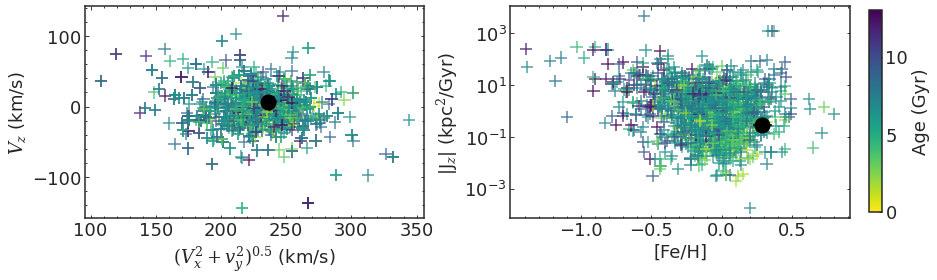

In [342]:
fig, ax=plt.subplots(ncols=2, figsize=(12, 4))

ax[0].scatter((comb.v_x**2+comb.v_y**2)**0.5, comb.v_z, s=150,  c=comb.age1, \
              marker='+', alpha=.8, cmap='viridis_r', vmin=0, vmax=13)
ax[1].scatter(comb['[Fe/H]'],  abs(comb.Jz), s=150,  c=comb.age1, \
              marker='+', alpha=.8, cmap='viridis_r', vmin=0, vmax=13)


ax[0].errorbar(236, 6.33, xerr=0.036, yerr=0.067, fmt='o', ms=15, c='k')
ax[1].errorbar(J1624_METAL[0], np.nanmedian(js[:,-1]*1000), xerr=J1624_METAL[-1],\
           yerr=np.nanstd(js[:,-1]*1000), marker='o', ms=15, c='k')

ax[0].set(xlabel=r'$(V_x^2+v_y^2)^{0.5}$ (km/s) ', ylabel=r'$V_z$ (km/s)')
ax[1].set(  xlabel='[Fe/H]', \
       ylabel=r'|J$_z$| (kpc$^2$/Gyr) ', yscale='log')

norm= mpl.colors.Normalize(vmin=0,vmax=13)
mp=mpl.cm.ScalarMappable(norm=norm, cmap='viridis_r')
cax = fig.add_axes([1.01, 0.25, .015, 0.7])
cbar=plt.colorbar(mp, cax=cax, orientation='vertical')
cbar.ax.set_ylabel(r'Age (Gyr)', fontsize=18)

plt.tight_layout()
for a in ax:
    a.minorticks_on()
plt.savefig(FIG_FOLDER+'/orbit_age_metallicity.jpeg', rasterized=True, bbox_inches='tight')

In [347]:
#select kinematic cu
kinematic_cut=comb_r.vtot <np.nanmedian(j1624c_total_v).value
metal_cut=np.logical_and(comb_r['[Fe/H]'] <0.5,\
                         comb_r['[Fe/H]'] >0.0)   
angle_cut=  abs(comb_r.Jz)< 1

In [348]:
MEDIAN_AGE=np.nanmedian(comb_r.age1[np.logical_and.reduce([metal_cut, \
                                angle_cut, kinematic_cut])])
STD_AGE=[np.percentile(comb_r.age1[np.logical_and.reduce([metal_cut, \
                                angle_cut, kinematic_cut])], 16), \
         np.percentile(comb_r.age1[np.logical_and.reduce([metal_cut, \
                                angle_cut, kinematic_cut])], 84)]

In [334]:
#sns

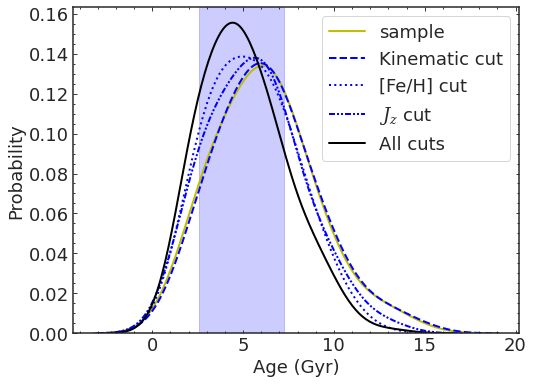

In [349]:
fig, ax=plt.subplots( figsize=(8, 6))
#_=ax.hist(comb.age1, histtype='step', bins='auto', lw=2, density=True, \
#          linestyle='--', color='r')
_=sns.kdeplot(comb_r.age1, bw=0.5, lw=2, ax=ax, \
              linestyle='-', label='sample',  color='y', alpha=0.5)

_=sns.kdeplot(comb_r.age1[kinematic_cut], bw=0.5, lw=2, ax=ax, \
              linestyle='dashed', label='Kinematic cut',  color='b', alpha=0.5)

_=sns.kdeplot(comb_r.age1[metal_cut], bw=0.5, lw=2, ax=ax, \
              alpha=0.5, color='b', linestyle='dotted', \
          label='[Fe/H] cut')

_=sns.kdeplot(comb_r.age1[angle_cut], bw=0.5, lw=2, ax=ax, \
               alpha=0.5, color='b', linestyle=(0, (3, 1, 1, 1, 1, 1)),
         label=r'$J_z$ cut')

_=sns.kdeplot(comb_r.age1[np.logical_and.reduce([metal_cut, angle_cut, kinematic_cut])], \
              bw=0.5, lw=2, ax=ax, \
               alpha=0.5, color='k',label='All cuts')

#ax.axvline( MEDIAN_AGE, c='k')
ax.axvspan(STD_AGE[0], STD_AGE[-1], alpha=0.2, color='blue')
ax.set(xlabel='Age (Gyr)', ylabel='Probability')
plt.legend()
ax.minorticks_on()
plt.savefig(FIG_FOLDER+'/age_constraints.pdf')

In [350]:
print (r'Age {}  -{} +{}'.format(MEDIAN_AGE, MEDIAN_AGE-STD_AGE[0],  \
                                 STD_AGE[1]-MEDIAN_AGE))

Age 4.7  -2.1500000000000004 +2.5699999999999994


In [337]:
#popsims.tools.plot_annotated_heatmap

In [345]:
comb.columns

Index(['ra', 'de', '[Fe/H]', 'age1', 'l_age1', 'u_age1', 'ra_gaia', 'de_gaia',
       'plx', 'eplx', 'pmra', 'epmra', 'pmde', 'epmde', 'rv', 'erv',
       'pmracosdec', 'age16P', 'age84P', 'Jr', 'Jphi', 'Jz', 'vtot', 'v_x',
       'v_y', 'v_z'],
      dtype='object')

In [ ]:
            # If this pyraf import isn't working, make sure you're in an iraf27
